<center> <font size="+1"> TP1 SIC 4102 </font> </center>

# Conditionnement (inversion d'un système linéaire carré), sensibilité au bruit

In [1]:
# Import de librairies
# %matplotlib inline
import sys
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../')
import tp2a
from scipy.linalg import hilbert

$
\newcommand{\bA}{\mathbf{A}}
\newcommand{\bx}{\mathbf{x}}
\newcommand{\by}{\mathbf{y}}
\newcommand{\be}{\mathbf{e}}
\newcommand{\RR}{\mathbb{R}}
\newcommand{\Argmin}{\mathrm{Argmin}}
\newcommand{\st}{\mathrm{s.t.}}
$

On considère le modèle d'observation suivant:
$$
\by = \bA\bx_0 + \be
$$
où $\bA\in\RR^{n\times n}$ est une matrice carrée donnée, $\by$ est le vecteur d'observation, $\bx_0$ est le vecteur des vraies données à reconstituer et $\be$ est un terme de bruit perturbateur.

## Génération d'un signal original $\bx_0$
Choisir $n$ de l'ordre de 500.
Générer pour $\bx_0$ des échantillons d'un signal sinusoidal avec une dizaine de périodes.

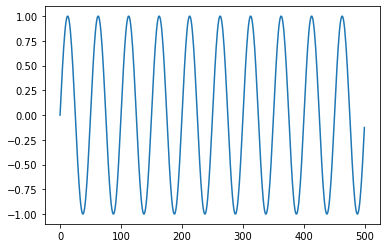

In [2]:
n = 500
x0 = np.sin(2*np.pi*np.arange(n)/n*10)
Fig_x0, Ax_x0 = plt.subplots(1, 1)
Ax_x0.plot(x0)

## Génération d'observations
Pour la matrice carrée $\bA$, on prévoira:
- une matrice dont les éléments sont aléatoires et indépendants, par exemple selon une loi Gaussienne,
- la matrice qui s'écrit comme le produit
$$
\bA = 
    \left[\begin{matrix}
    1      & 0     & \dots  & 0      \\
    0      & 1/2   &        & \vdots \\
    \vdots & 0     & \ddots &  0     \\
    0      & \dots &   0    & 1/n       
    \end{matrix}\right]
    \left[\begin{matrix}
        1      & 0 & \dots  &       & 0 \\
        1      & 1 & 0      & \dots & 0 \\
        \vdots &   & \ddots &       &   \\
        1      & 1 & \dots  &       & 1
    \end{matrix}\right] \,,
$$
- une matrice donnée par `tp2a.educ.bad_cond_matrix`,
- la matrice de Hilbert (importer la fonction `scipy.linalg.hilbert`).

Vérifier que $\bA$ est inversible et calculer son conditionnement.

Simuler des observations non bruitées $\by_0=\bA\bx_0$; générer un bruit (dont on fixera la puissance en fonction du SNR en dB) et les observations bruitées $\by$.

cond(A) = 2.827841384517892e+16


Text(0.5, 1.0, 'Observations with noise')

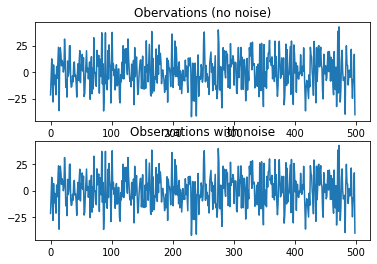

In [4]:
# génération d'une matrice A
# A = np.random.randn(n,n)
A = tp2a.educ.bad_cond_matrix((n, n), 1e17)
# A = hilbert(n)
print('cond(A) = {0}'.format(np.linalg.cond(A)))
# observations non bruitées
y0 = A.dot(x0)
# ### ajout de bruit sur les observations
Py = (y0**2).sum()/n
snr_dB = +100 #+np.infty
sigma_e = np.sqrt(Py*np.exp(-snr_dB/10))
e = sigma_e*np.random.randn(n)
yn = y0 + e
# ### tracé des observations
Fig_Observ, Ax_Observ = plt.subplots(2, 1)
Ax_Observ[0].plot(y0)
Ax_Observ[0].set_title('Obervations (no noise)')
Ax_Observ[1].plot(yn)
Ax_Observ[1].set_title('Observations with noise')

## Estimation par inversion du système

Calculer les estimées de $\bx_0$ suivantes:
- $\hat{\bx}_0$ que l'on obtient à partir d'observations non bruitées $\hat{\bx}_{0} = \bA^{-1}\by_0$,
- $\hat{\bx}_n$ que l'on obtient à partir d'observations bruitées $\hat{\bx}_{0} = \bA^{-1}\by$,

<u>Indication</u>: on utilisera la fonction solve pour résoudre un système linéaire; une comparaison en temps de calcul avec d'autres options pourrait être un point intéressant.

No noise 	 np.linalg.norm(x0 - xhat0): 17.6 	 1/n*np.linalg.norm()^2: 0.618
With noise 	 np.linalg.norm(x0 - xhat): 1.81e+14	 1/n*np.linalg.norm()^2: 6.58e+25
Puissance de y 251 et du bruit 0.0116


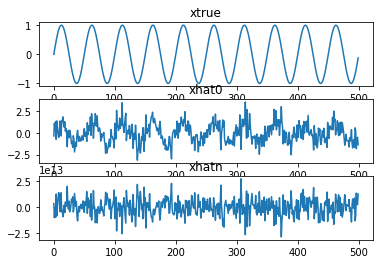

In [5]:
xhat0 = np.linalg.solve(A, y0)
xhatn = np.linalg.solve(A, yn)

Fig_xhat, Ax_xhat = plt.subplots(3, 1)
Ax_xhat[0].plot(x0)
Ax_xhat[0].set_title('xtrue')
Ax_xhat[1].plot(xhat0)
Ax_xhat[1].set_title('xhat0')
Ax_xhat[2].plot(xhatn)
Ax_xhat[2].set_title('xhatn')

print('No noise \t np.linalg.norm(x0 - xhat0): {0:2.3g} '
      '\t 1/n*np.linalg.norm()^2: {1:.3g}'
      .format(np.linalg.norm(x0-xhat0), 1/n*np.linalg.norm(x0-xhat0)**2))
print('With noise \t np.linalg.norm(x0 - xhat): {0:2.3g}'
      '\t 1/n*np.linalg.norm()^2: {1:.3g}'
      .format(np.linalg.norm(x0-xhatn), 1/n*np.linalg.norm(x0-xhatn)**2))
print('Puissance de y {0:2.3g} et du bruit {1:2.3g}'
      .format(Py, (e**2).sum()/n))

## Comparaison avec estimateur RIDGE

Calculer les estimées de $\bx_0$ suivantes:
- $\hat{\bx}_n$ que l'on obtient à partir d'observations bruitées $\hat{\bx}_{0} = \bA^{-1}\by$,
- $\hat{\bx}_{ridge}$ (fonction `tp2a.educ.ridge`, à reprogrammer)

In [6]:
from numpy.random import randn
from numpy.linalg import svd, inv, solve
from numpy import diag, eye

def inv_sol(A, b):
    return inv(A).dot(b)
    #raise UserWarning('Reprogrammer cette fonction')


def approx_l2(A, b):
    B=np.dot(np.transpose(A),A)
    Ay=np.transpose(A).dot(b)
    return inv(B).dot(Ay)
    #raise UserWarning('Reprogrammer cette fonction')


def least_l2_pen(A, b):
    return A.transpose().dot(inv(A.dot(A.transpose()))).dot(b)
    #raise UserWarning('Reprogrammer cette fonction')


def ridge(A, b, lamb):
    B=np.dot(np.transpose(A),A)+lamb*np.eye(A.shape[0])
    Ay=np.transpose(A).dot(b)
    return inv(B).dot(Ay)
    #raise UserWarning('Reprogrammer cette fonction')

With noise 	 np.linalg.norm(x0 - xhat): 1.81e+14	 1/n*np.linalg.norm()^2: 6.58e+25
With noise 	 np.linalg.norm(x0 - xridge): 3.84	 1/n*np.linalg.norm()^2: 0.0296
Puissance de y 251 et du bruit 0.0116


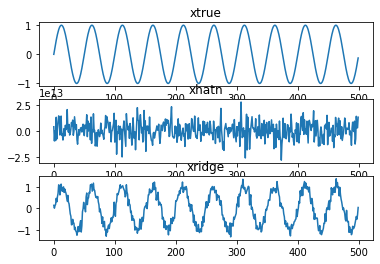

In [7]:
xhatn = np.linalg.solve(A, yn)
xridge = ridge(A, yn, 0.0001)

Fig_xhat, Ax_xhat = plt.subplots(3, 1)
Ax_xhat[0].plot(x0)
Ax_xhat[0].set_title('xtrue')
Ax_xhat[1].plot(xhatn)
Ax_xhat[1].set_title('xhatn')
Ax_xhat[2].plot(xridge)
Ax_xhat[2].set_title('xridge')

print('With noise \t np.linalg.norm(x0 - xhat): {0:2.3g}'
      '\t 1/n*np.linalg.norm()^2: {1:.3g}'
      .format(np.linalg.norm(x0-xhatn), 1/n*np.linalg.norm(x0-xhatn)**2))
print('With noise \t np.linalg.norm(x0 - xridge): {0:2.3g}'
      '\t 1/n*np.linalg.norm()^2: {1:.3g}'
      .format(np.linalg.norm(x0-xridge), 1/n*np.linalg.norm(x0-xridge)**2))
print('Puissance de y {0:2.3g} et du bruit {1:2.3g}'
      .format(Py, (e**2).sum()/n))